In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../../common_code')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 
from formation_channels import * 


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## Code to calculate formation channel contributions to the local merger rate 

the code works directly with the Hdf5 files to read out the weights of the formation channel contributions <br>
The required data is in the dataframe group "formationchannel_z_rates" , which stores the formation channel rates for all formation channels for all redshifts. <br>
We simply take the first value to get the local redshift <br>
The original data is created, and added to the hdf5 files using the code:  <br> 
`add_fc_rates_to_hdf5.py` in `Double-Compact-Object-Mergers/otherCode/add_fc_rates_to_hdf5.py` located in my Github (Floor Broekgaarden) <br>


In [2]:
def obtain_MSSFR_order(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
    merger_ratio_z = np.zeros(len(MSSFRnameslist))
    for ind_L, MSSFRname in enumerate(MSSFRnameslist):

        full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
        fparam_key = "formationchannel_z_rates"
        header = "fraction_" + whichChannel + "_" + MSSFRname
        fdata = h5.File(full_data_path,'r')
        merger_ratio_z[ind_L] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
        fdata.close()
        
    ordered_ind = np.argsort(merger_ratio_z)
    ordered_MSSFR_list = np.asarray(MSSFRnameslist)[ordered_ind]
    
    return ordered_MSSFR_list


def draw_arrows(axes=None):

    
    textbox_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.3)
    

    ar_c = 'k' #'turquoise'
    ar_lw=4
    
    # BHBH
    axe =axes[0]
    # properties  arrow 
    strr = r"\textbf{Only Stable}" + '\n' + r'\textbf{Mass Transfer}' + '\n'   + r"\textbf{channel (II)}" + '\n'   + r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.7
    x_xytext, y_xytext = 21.8, 0.3
    conn = "angle3,angleA=90,angleB=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)    
    
    
    

    # BHNS 
    axe =axes[1]
    # properties  arrow 
    strr = r"\textbf{Classic CE}" + '\n' + r'\textbf{channel (I)}' + '\n' +r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.14
    x_xytext, y_xytext = 20.9, 0.54
    conn = "angle,angleA=-90,angleB=180,rad=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)
    
    
    
    # NSNS 
    axe =axes[2]
    # properties  arrow 
    strr = r"\textbf{Double-core CE}" + '\n' + r'\textbf{channel (IV)}' + '\n' +r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.7
    x_xytext, y_xytext = 20.9, 0.3
    conn = "angle3,angleA=90,angleB=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)
    
    return 



def obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/'):
    """
    function that returns the list of redshifts for which the simulations have been run
    
    """
    
    BPSmodelName='A'
    DCOtype='BNS'
    path_ = pathData + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(path, 'r')
    redshifts = fdata['redshifts']['redshift'][...].squeeze()
    fdata.close()
    return redshifts 




def plotFormationChannelRates_vbars_fromHdf5file(which_z_ind=0, pathData='name', ordered_MSSFR_list=True):
    
    """
    parameters:
    which_z_ind=0 ; index of the redshift bin for which we want to plot the formation channel contributions, default is 0, which gives the local merger rates
    pathdata = location path to the hdf5 files. See example
    
    """
    
    ncols, nrows = 1,3
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(24,14), gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types, TypesLabels      = ['BBH', 'BHNS', 'BNS'], ['BHBH', 'BHNS', 'NSNS']
    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    
    dx = 0.4 #0.3
    dxrange = np.linspace(-dx, +dx, len(MSSFRnameslist)+1) #+ ind_m
    dxlen = (2*dx)/len(MSSFRnameslist)
    #####
    
    # calculate the redshift at which to run it for 
    redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
    print('running for z=', redshifts[which_z_ind])
    whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
    #Iterate over DCO type
    for ind_t, DCOtype in enumerate(Types):
        print('at DCO type', DCOtype)
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]

        # iterate over cosmic integration perscriptions 
#         for ind_L, MSSFRname in enumerate(MSSFRnameslist):
        
        
        if ordered_MSSFR_list==True:
            SFRD_list = obtain_MSSFR_order(BPSmodelName='A')
        else:
            SFRD_list = MSSFRnameslist
        print('will plot SFRD models in this order: ', SFRD_list)
        for ind_L, MSSFRname in enumerate(SFRD_list):
            ratesRatio_low = np.zeros(nModels) #lower y-values for bins 
            ratesRatio     = np.zeros(nModels) # upper y-values for bins 

            x_positions_ = range(nModels) # locations on the x-axis for bins 
            x_positions = np.asarray(x_positions_) + dxrange[ind_L] # for each cosmic integration move a bit to the right 
            
            #iterate over the formation channels 
            for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE',  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
                merger_ratio_z = np.zeros(nModels)
                #iterate over stellar evolution models 
                for ind_m, BPSmodelName in enumerate(BPSnameslist):
                    full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                    fparam_key = "formationchannel_z_rates"
                    header = "fraction_" + whichChannel + "_" + MSSFRname
                    fdata = h5.File(full_data_path,'r')
                    merger_ratio_z[ind_m] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
#                     fdata.close()
                    
                    if whichChannel=='classic':
                        header = "fraction_" + 'vi' + "_" + MSSFRname
                        merger_ratio_z[ind_m] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
                    elif whichChannel=='stable B no CEE':
                        header = "fraction_" + 'vii' + "_" + MSSFRname
                        merger_ratio_z[ind_m] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

                    fdata.close()
                

                # update the y-values for the top values of the bin 
                ratesRatio += np.asarray(merger_ratio_z)
                # plot the bars 
                axe.bar(x_positions, height=(ratesRatio-ratesRatio_low),  bottom=ratesRatio_low, color=channelColorDict[whichChannel], alpha=1, width=dxlen, zorder=100)
                
                # update the y-values for the bottem of the bins 
                ratesRatio_low += np.asarray(merger_ratio_z)


        
        # draw custom grid lines in plot 
        xmin, xmax = -0.8, nModels +1. # change nModels + 1 to len(df.T)
        xx = np.linspace(xmin,xmax,15) # just mock x-axes to draw lines
        for ll in [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=0.9, zorder=0)
        axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )


        ### make up axes ###
        axe.set_xlim(xmin, xmax)
    
        ylabel = r'\textbf{rate fraction}' # $\,\mathcal{R}_{\rm{m}}$' # ^{{0}}     
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model}' # plot x-axes label for bottom panel
            axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+4)
        else:
            xlabel=r'  $\_$ '     
            axe == layoutAxesNoXlabel(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+4)
        


        # set physical labels on bottom
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
            ind_label = dictFormationChannelIndex[whichChannel]-1
        else:
            axe.set_xticks([])
            axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.99, 0.94, r'\textbf{%s}'%TypesLabels[ind_t] , rotation = 0, fontsize = fs+3, color = 'k', va='top', ha = 'right',transform=axe.transAxes, zorder=1E3)#, weight = 'bold')
        axe.text(0.99, 0.85, r'\textbf{detections}' , rotation = 0, fontsize = 17, color = 'k', va='top', ha = 'right',transform=axe.transAxes, zorder=1E3)#, weight = 'bold')
        whichz_short = str(np.round(redshifts[which_z_ind], 1)) 
        axe.text(0.99, 0.77, r'$z \approx $ \textbf{%s}'%whichz_short , rotation = 0, fontsize = 17, color = 'k', va='top', ha = 'right',transform=axe.transAxes, zorder=1E3)#, weight = 'bold')


        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)
            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-6, rotation=30)#, orientation=30)    
     

    ## make legend 
    x__ = -100*np.ones(5)
    for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii', 
        plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
    lgd = f.legend(fontsize=fs-1, ncol=2,bbox_to_anchor=(.9, 1.124)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  



    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.07)#2)
    plt.savefig('./FormationChannels_z' + whichz  + '_vbars.pdf', transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')#, loc='upper center')
    plt.savefig('./FormationChannels_z' + whichz  + '_vbars.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')#, loc='upper center')
    plt.show()
    plt.close()
    
    
    return







running for z= 0.19230769230769232
at DCO type BBH
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']
at DCO type BHNS
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']
at DCO type BNS
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']


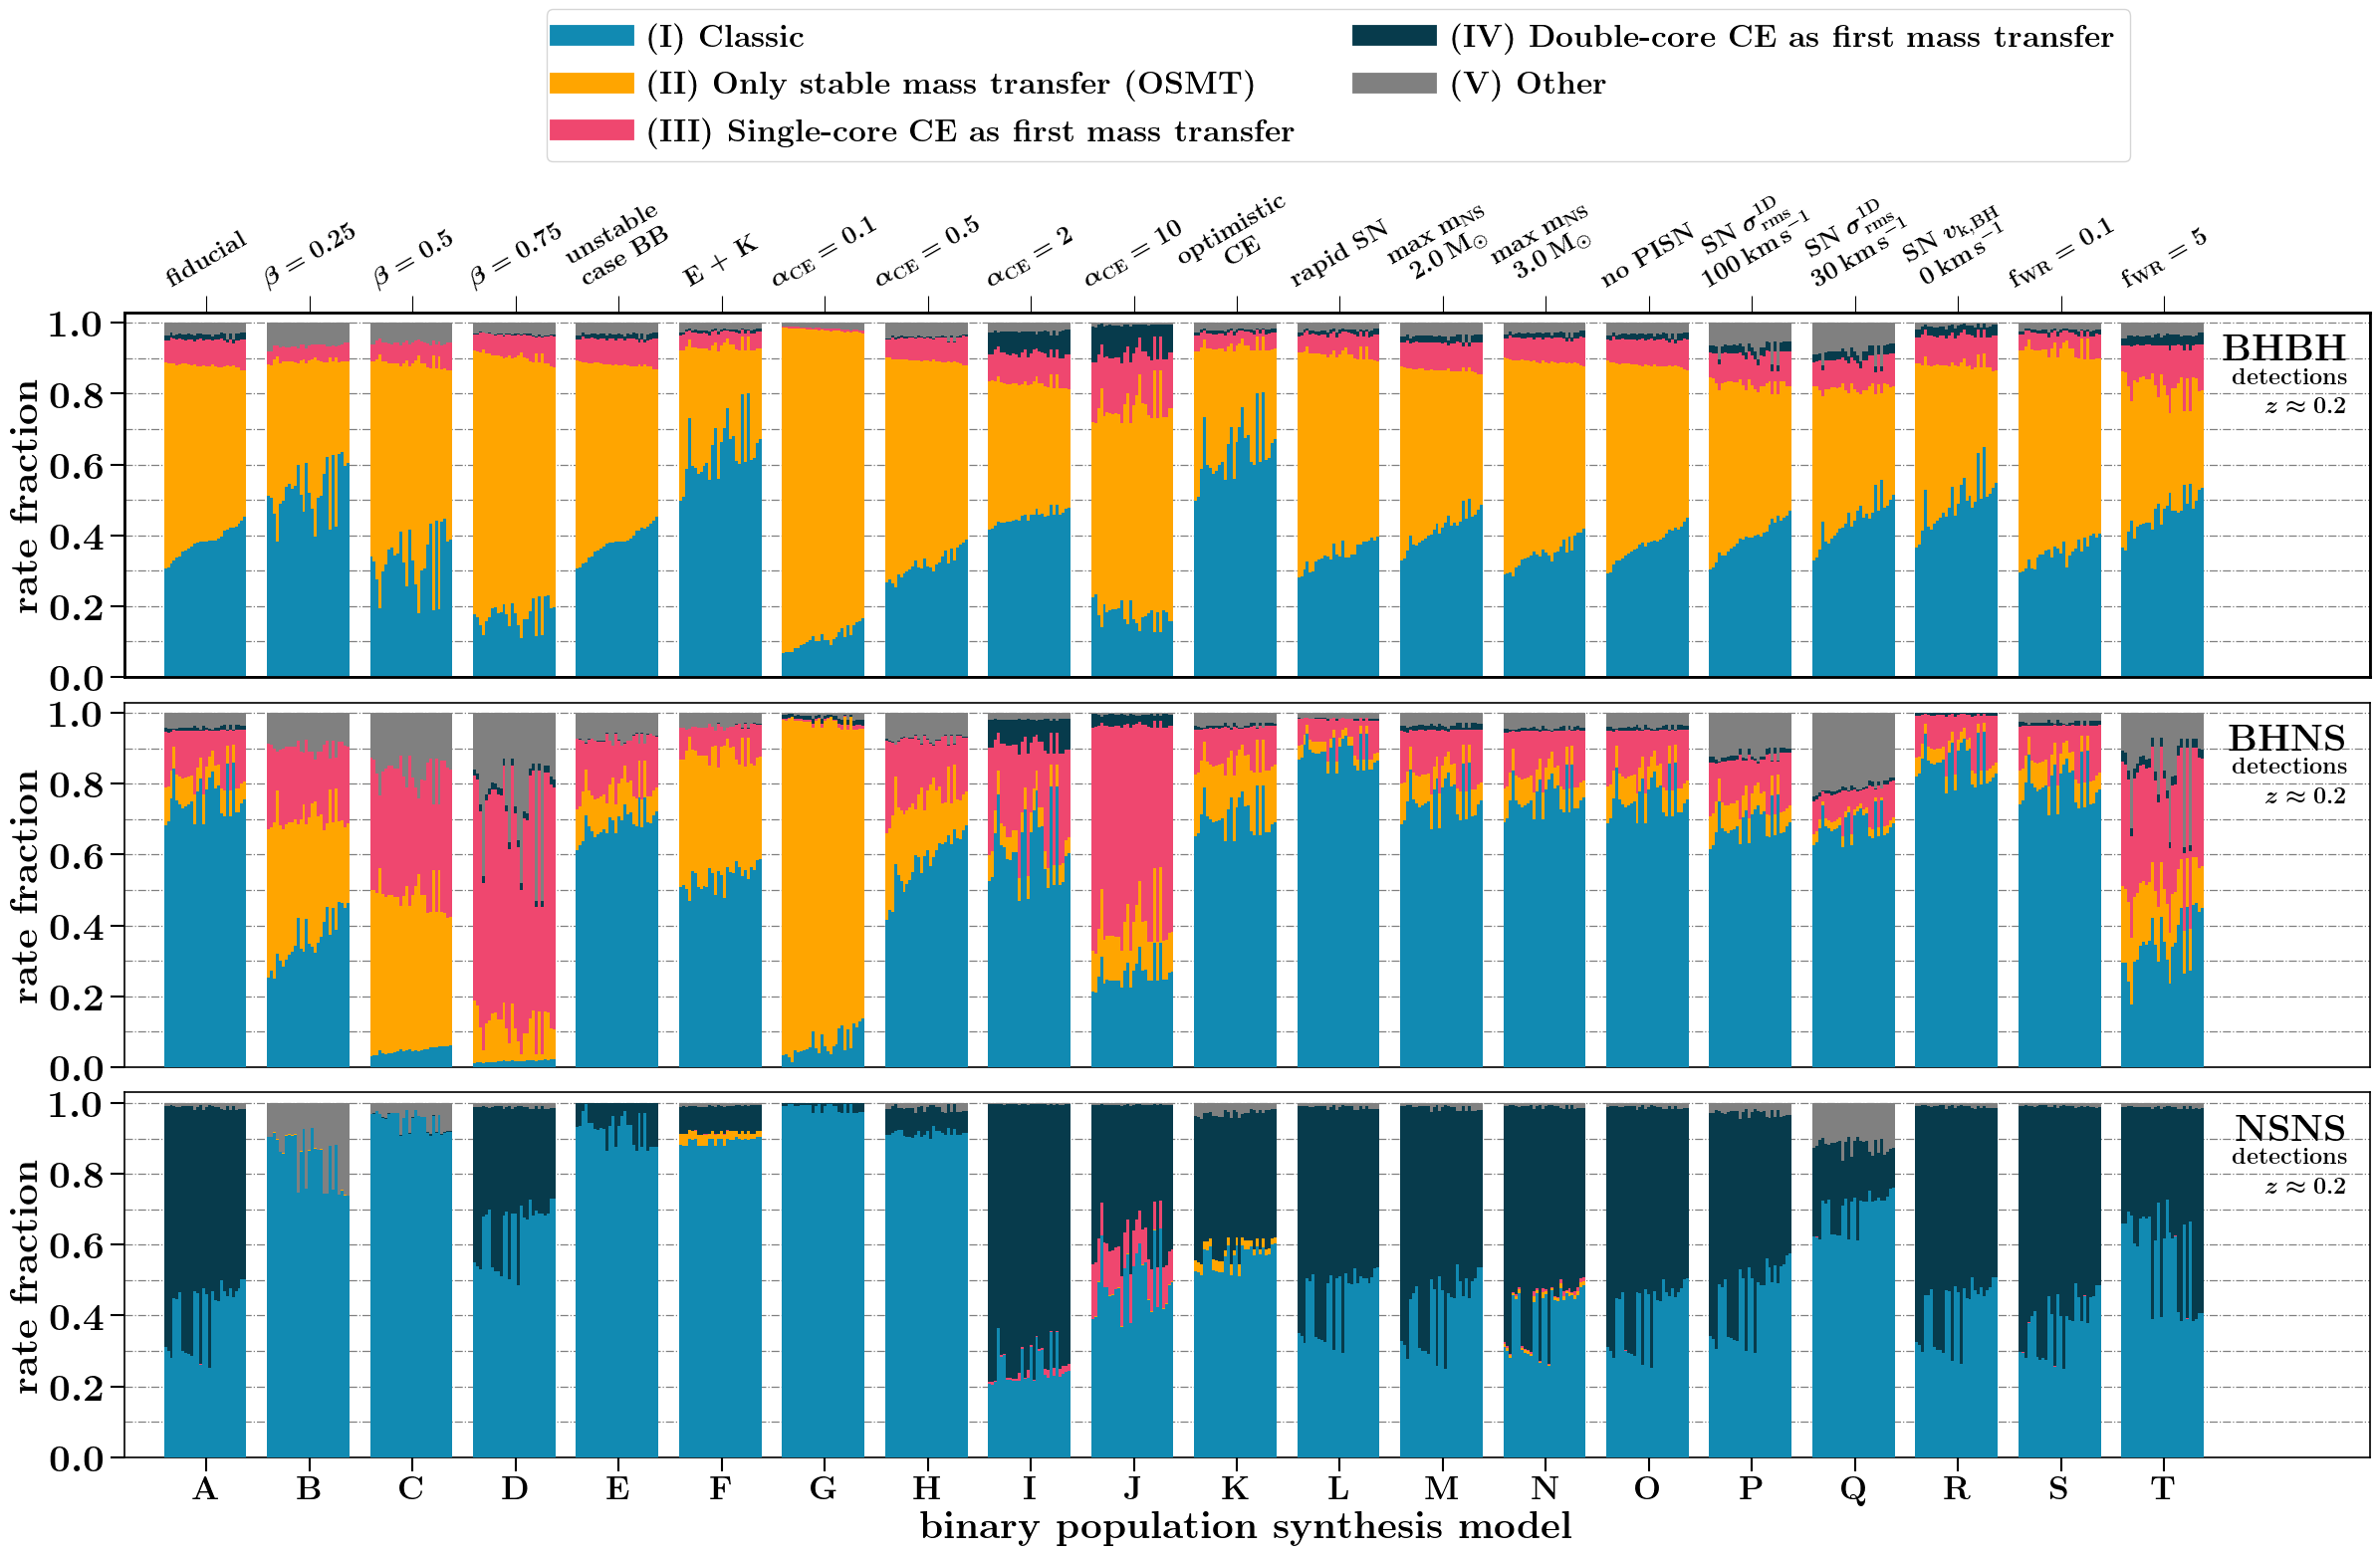

In [3]:
pathData='/Volumes/SimonsFoundation/DataDCO/'
ylims =[[0,1.03],[0,1.03],[0,1.03]]
plotFormationChannelRates_vbars_fromHdf5file(which_z_ind=0, pathData=pathData, ordered_MSSFR_list=True)



### now make the same figure at higher redshifts
by changing the which_z_ind

running for z= 3.269230769230769
at DCO type BBH
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']
at DCO type BHNS
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']
at DCO type BNS
will plot SFRD models in this order:  ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
 '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
 '131' '121' '311' '111']


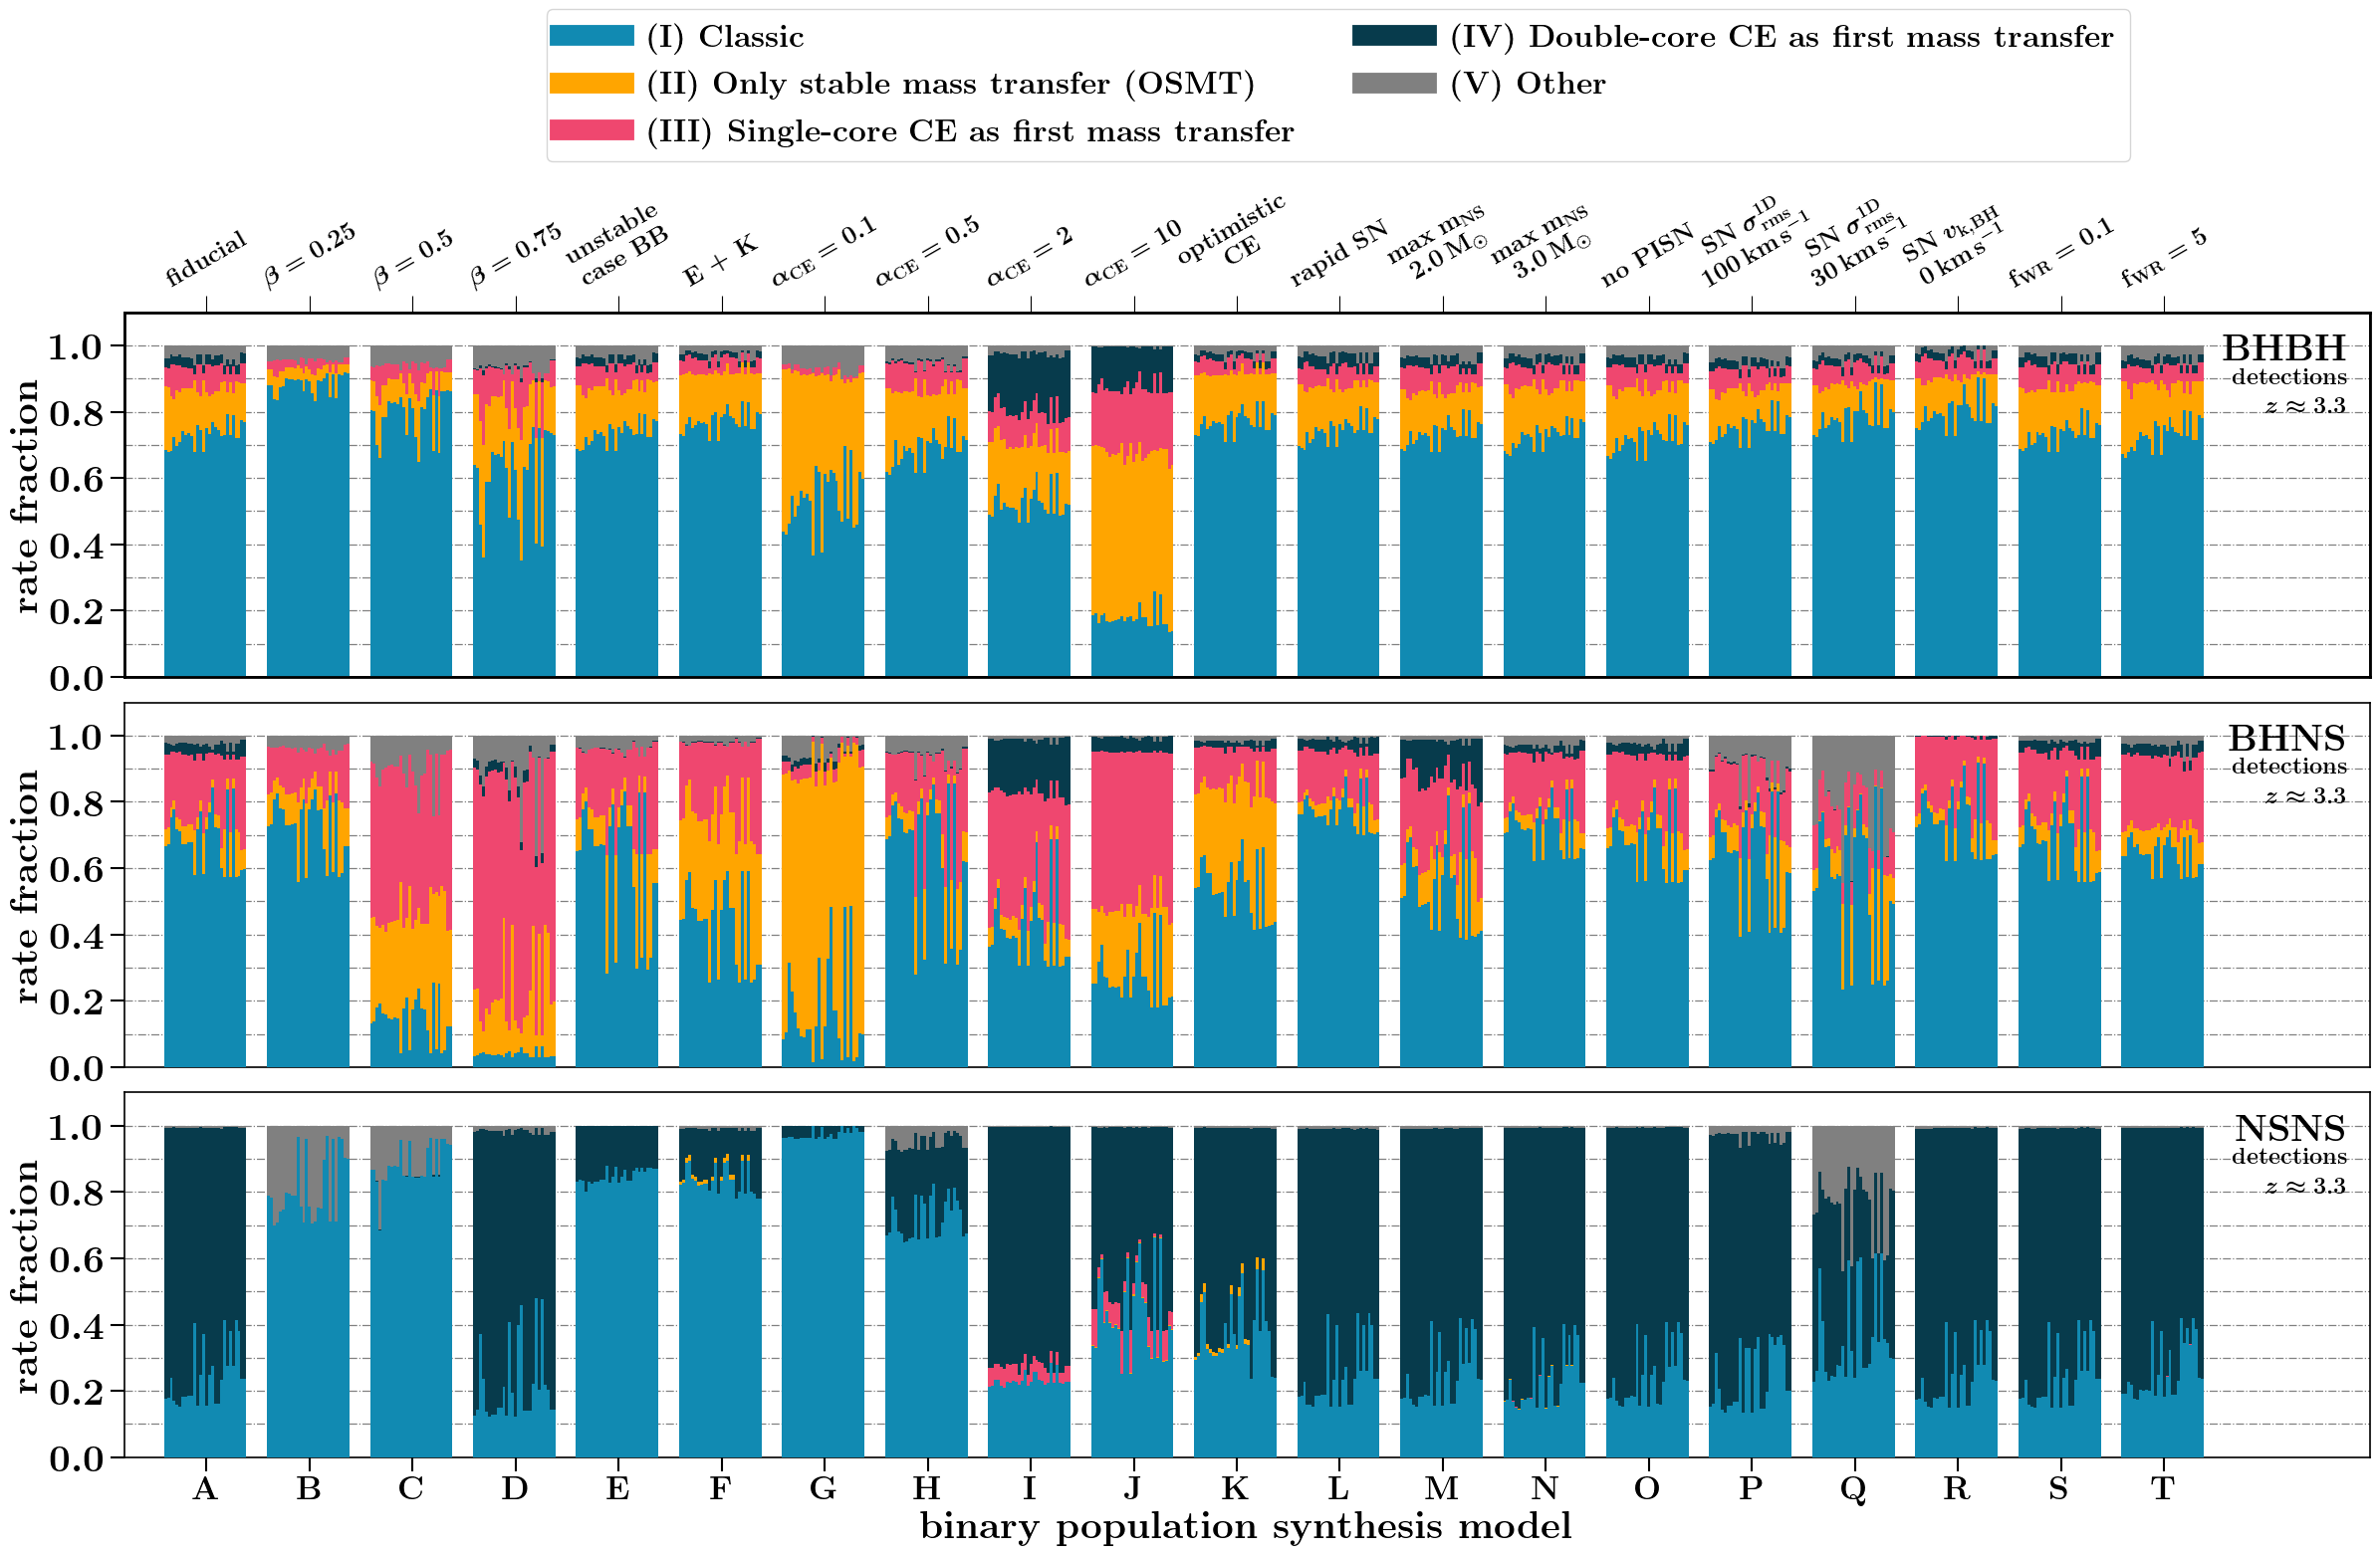

In [4]:

pathData='/Volumes/SimonsFoundation/DataDCO/'
ylims =[[0,1.1],[0,1.1],[0,1.1]]
plotFormationChannelRates_vbars_fromHdf5file(which_z_ind=8, pathData=pathData)



### save data into csv file:
```/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/produceDataCode/write_formation_channel_rates_to_CSV.py```
run this code, which produces CSV files for each MSSFR and DCOtype for the fractions 

### Extra: plot all intrinsic rates for all models


In [5]:
fs = 28 



NSNSrate0 = [13.0, 1900.0] # Gpc-3 yr-1 from: GWTC-2-z-independent Section 5.3  https://arxiv.org/abs/2010.14533 and https://ui.adsabs.harvard.edu/abs/2021arXiv210801045T/abstract
BHBHrate0 = [16.0, 130.0] #for minimum and maximum of possible local merger rates estimates,  and https://ui.adsabs.harvard.edu/abs/2021arXiv210801045T/abstract
BHNSrate0 = [7.4,  320.0] # min and max range from the two estimates based on GW200115 and GW200105



def plot_intrinsic_rates(pathData='/Volumes/SimonsFoundation/DataDCO/'):
    
    ncols, nrows=1, 3
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(26,18), 
                  gridspec_kw={"width_ratios":[2], "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']
    TypeColours = ['#8da0cb','#66c2a5','#fc8d62']
    ObservedRatesList = [BHBHrate0, BHNSrate0, NSNSrate0]
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    MSSFRcolors = sns.color_palette("husl", len(MSSFRnameslist)) 
    ylabel = r'$\mathcal{R}_{\rm{m}}^{{0}} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    which_z_ind = 0 # gives rates at redshift 0         
    fparam_key = "formationchannel_z_rates"
    
    for ind_t, DCOtype in enumerate(Types):
        for ind_L, MSSFRname in enumerate(MSSFRnameslist):
            rates = np.zeros(len(BPSnameslist))
            for ind_bps, BPSmodelName in enumerate(BPSnameslist):
            
                full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                header = "rate_" + "total" + "_" + MSSFRname
                fdata = h5.File(full_data_path,'r')
                rates[ind_bps] =  fdata[fparam_key][header][...].squeeze()[which_z_ind] # [which_z_ind = 0] gives at lowest redshift
                fdata.close()

            COLOR=TypeColours[ind_t] 
            

            if MSSFRname=='112':
                COLOR='k'
                zorder=10
                label=MSSFRnameslist[ind_L] 
                ls = '--'
                ALPHA=1
                lw=3.6
            elif MSSFRname=='312':
                COLOR='c'
                zorder=10
                label=MSSFRnameslist[ind_L]
                ls = ':'
                ALPHA=1
                lw=3.6
            elif MSSFRname=='133':
                COLOR='red'
                zorder=10
                label=MSSFRnameslist[ind_L]
                ls = ':'
                ALPHA=1
                lw=3.6

            else:
                # 'lightgray' #MSSFRcolors[ind_L]
                zorder=2
                label=None    
                ls = MSSFRlinestyles[0]
                ALPHA=0.24
                lw=3
            

# ['232' '222' '212' '000' '223' '233' '332' '132' '322' '122' '231' '333'
#  '312' '221' '133' '112' '213' '323' '123' '211' '331' '313' '321' '113'
#  '131' '121' '311' '111']                
                
            
            axe[ind_t].plot(range(len(rates)), rates, c=COLOR, lw=lw, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
            axe[ind_t].scatter(range(len(rates)), rates, c=COLOR, s=105, label=label, zorder=zorder, alpha=1, linestyle=ls)
            

            


        ## set some of the axes ranges 
        xmin = -0.8
        xmax = nModels -0.25 # change to len(df.T)


        # FIX
        fix=1
        

        xx = np.linspace(xmin,xmax,15)
        
        
        # if plotting intrinsic, add the local detected merger rates inferred from obesrvations. 
        min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
        max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
        if ind_t in [0, 1, 2]:
            axe[ind_t].fill_between(xx, min_obs_rate, max_obs_rate, alpha=0.2, color=TypeColours[ind_t], zorder=1)




#         # make up axes
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model} $\mu$'
        else:
            xlabel=r'  $\_$ '
            
        axe[ind_t].set_xlim(xmin, xmax)
        axe[ind_t] == layoutAxes(axe[ind_t], nameX=xlabel, nameY=ylabel, setMinor=False)
        axe[ind_t].set_yscale('log')
    
         # Set the tick labels
        axe[ind_t].set_xticks(range(nModels))
    
    
        
        #############################
        
    
        axe[ind_t].set_xticklabels(BPSnameslist)
        
        axe[ind_t].set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
        
#         axe[ind_t].text(xloc_text-0.2, 0.12, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', ha = 'left',transform=axe[ind_t].transAxes)#, weight = 'bold')
    


        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe[ind_t].twiny()
            ax2y.set_xlim(xmin, xmax)

            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-10, rotation=30)#, orientation=30)      

    
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe[ind_t].set_xticks(range(nModels))
            axe[ind_t].set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe[ind_t].set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
        else:
            axe[ind_t].set_xticks([])
            axe[ind_t].set_xticklabels( () )
    print(nModels, 'nModels')
    
    #############################################################################
    #############################################################################
    # the following block marks the simulations where all 3 DCO flavors are consistent with LIGO Virgo 90% credible intervals with a red cross.      
    for ind_L, MSSFRname in enumerate(MSSFRnameslist):
        for ind_t, DCOtype in enumerate(Types):
            rates = np.zeros(len(BPSnameslist))
            for ind_bps, BPSmodelName in enumerate(BPSnameslist):
            
                full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                header = "rate_" + "total" + "_" + MSSFRname
                fdata = h5.File(full_data_path,'r')
                rates[ind_bps] =  fdata[fparam_key][header][...].squeeze()[which_z_ind] # [which_z_ind = 0] gives at lowest redshift
                fdata.close()


            if ind_t==0:
                rate_BHBH = rates
            elif ind_t==1:
                rate_BHNS = rates
            elif ind_t==2:
                rate_NSNS = rates 
                

        maskBHBH = (rate_BHBH>= BHBHrate0[0]) & (rate_BHBH <=BHBHrate0[1])
        maskBHNS = (rate_BHNS>= ObservedRatesList[1][0]) & (rate_BHNS <=ObservedRatesList[1][1])
        maskNSNS = (rate_NSNS>= ObservedRatesList[2][0]) & (rate_NSNS <=ObservedRatesList[2][1])

        maskGWTC2 = (maskNSNS==1) & (maskBHNS==1) & (maskBHBH==1) 

        # draw the red crosses 
        axe[0].scatter((np.array(range(len(rates))))[maskGWTC2], rate_BHBH[maskGWTC2], s=350, c='r', marker='x', zorder=1E8)
        axe[1].scatter((np.array(range(len(rates))))[maskGWTC2], rate_BHNS[maskGWTC2], s=350, c='r', marker='x', zorder=1E8)
        axe[2].scatter((np.array(range(len(rates))))[maskGWTC2], rate_NSNS[maskGWTC2], s=350, c='r', marker='x', zorder=1E8)


        
    # cool label plotting in top of the panel with the stellar evolution prescriptions change; adopted from Tom Wagg's LISA paper:  
    offset = 0.3
    for lower, upper, color, label, lc, lfs in [(1, 5, "#FF9739", "Mass Transfer", "#9B5A07", fs), (6, 10, "#FFE300", "Common-Envelope", "#C3A900", fs),
                                       (11, 17, "#089CA3", "Supernovae", "#08684E", fs), (17.9, 19.1, "#7030A0", "Stellar Winds", "#002060", 0.85*fs)]:
        axe[0].axvspan(lower - offset, upper + offset, 0.89, 0.98, color="white", linewidth=0, zorder=1)
        axe[0].axvspan(lower - offset, upper + offset, 0.89, 0.98, color=color, alpha=0.63, linewidth=0, zorder=1)
        if label=="Stellar Winds":
            axe[0].annotate(label, xy=(((upper - lower) / 2 + 0.28 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color='k', fontsize=lfs, fontname="Avenir", zorder=12)
        else:
            axe[0].annotate(label, xy=(((upper - lower) / 2 + 0.5 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color='k', fontsize=lfs, fontname="Avenir", zorder=12)
               

    ################################################################
    ################################################################
    ################################################################
     
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.06)#2)
#     plt.savefig('./Rates_with_GWTC3.png', dpi=300, transparent=False)#,\
#     plt.savefig('./Rates_with_GWTC3.pdf')#,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.close()

    return




In [6]:
def plotFormationChannelRates(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
    """
    parameters
    
    """
    
    ncols=1
    nrows=3
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,14), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']

    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    

    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

    
    # calculate the redshift at which to run it for 
    redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
    print('running for z=', redshifts[which_z_ind])
    whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
    #Iterate over DCO type
    for ind_t, DCOtype in enumerate(Types):
        print('at DCO type', DCOtype)
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]
        
        for ind_L, MSSFRname in enumerate(MSSFRnameslist):

            #iterate over the formation channels 
            for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE',  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
                merger_ratio_z = np.zeros(nModels)
                #iterate over stellar evolution models 
                for ind_m, BPSmodelName in enumerate(BPSnameslist):
                    full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                    fparam_key = "formationchannel_z_rates"
                    header = "fraction_" + whichChannel + "_" + MSSFRname
                    fdata = h5.File(full_data_path,'r')
                    merger_ratio_z[ind_m] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
#                     fdata.close()
                    
                    if whichChannel=='classic':
                        header = "fraction_" + 'vi' + "_" + MSSFRname
                        merger_ratio_z[ind_m] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
                    elif whichChannel=='stable B no CEE':
                        header = "fraction_" + 'vii' + "_" + MSSFRname
                        merger_ratio_z[ind_m] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

                    fdata.close()
                


                ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'    



                if MSSFRname=='112':
                    zorder=10
                    label=MSSFRnameslist[ind_L] 
                    ls = MSSFRlinestyles[1]
                    ALPHA=1
#                 elif MSSFRname=='312':
#                     zorder=10
#                     label=MSSFRnameslist[ind_L]
#                     ls = MSSFRlinestyles[2]
# #                     print('label=', label)
#                     ALPHA=1
                else:
                    zorder=2
                    label=None    
                    ls = MSSFRlinestyles[0]
                    ALPHA=0.1


                ratesRatio = merger_ratio_z
                ind_color = dictFormationChannelIndex[whichChannel]
                axe.plot(range(len(ratesRatio)), ratesRatio, c=channelColorDict[whichChannel], lw=2, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
                axe.scatter(range(len(ratesRatio)), ratesRatio, c=channelColorDict[whichChannel], s=50, label=None, zorder=zorder+1, alpha=1, linestyle=ls) #c=BPScolors




        xmin = -0.8
        xmax = nModels +0.5 # change to len(df.T)
        xx = np.linspace(xmin,xmax,15)


        for ll in [0.25, 0.5, 0.75]:
            axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=1.5, zorder=0)
            axe.text(17.5-0.04, ll, str(ll) +r'$\,$' , rotation = 0, fontsize = fs-4, color = 'gray', va='bottom', ha = 'right')#, weight = 'bold')
        axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )



#       # make up axes
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model} $\mu$'
        else:
            xlabel=r'  $\_$ '

        axe.set_xlim(xmin, xmax)
        axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
#             axe.set_yscale('log')

        print(BPSnameslist)
        print(nModels)
        # set physical labels on bottom
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
            ind_label = dictFormationChannelIndex[whichChannel]-1
        else:
            axe.set_xticks([])
            axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.98, 0.97, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', va='top', ha = 'right',transform=axe.transAxes)#, weight = 'bold')



        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)

            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-4, rotation=30)#, orientation=30)    
     

    ## make legend 
    x__ = -100*np.ones(5)
    for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii',
        plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
    lgd = f.legend(fontsize=fs-5, ncol=3,bbox_to_anchor=(.99, 1.10)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.09)#2)
#     plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight') #, loc='upper center')
    plt.show()
    plt.close()

    return




running for z= 0.9615384615384617
at DCO type BBH
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BHNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20


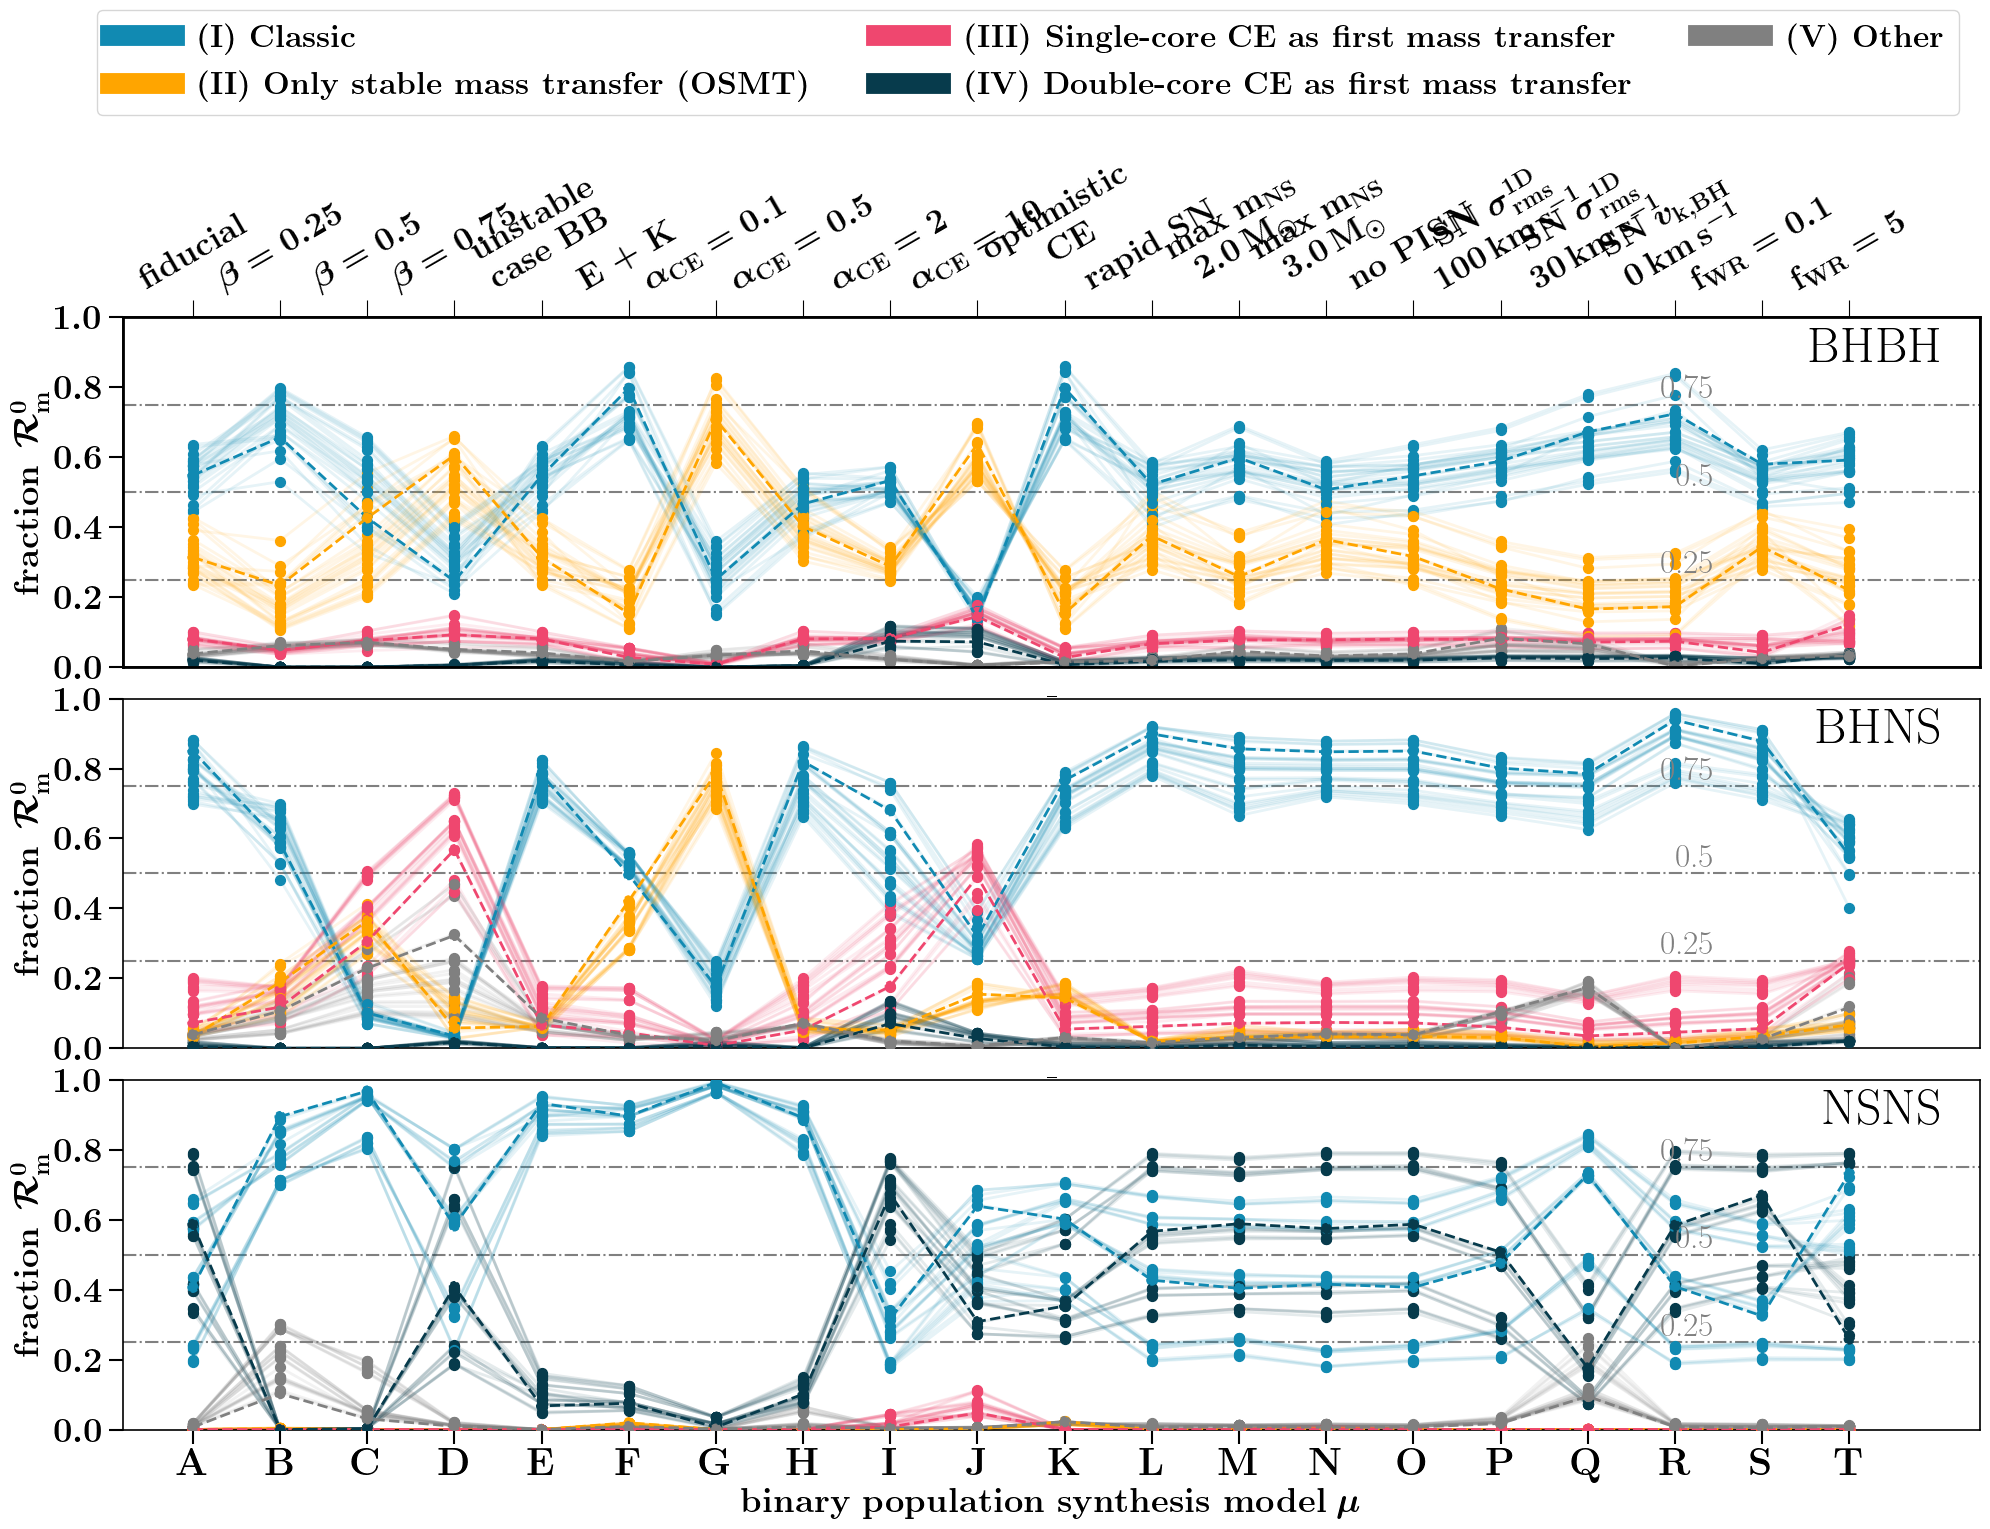

In [7]:
pathData='/Volumes/SimonsFoundation/DataDCO/'
# ylims =[[0,1.03],[0,1.03],[0,1.03]]
ylims =[[0,1],[0,1],[0,1]]
plotFormationChannelRates(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=2)


In [8]:
def plotFormationChannelRates_MSSFR(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
    """
    parameters
    
    """
    
    ncols=1
    nrows=3
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,14), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']

    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    

    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

    
    # calculate the redshift at which to run it for 
    redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
    print('running for z=', redshifts[which_z_ind])
    whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
    #Iterate over DCO type
    for ind_t, DCOtype in enumerate(Types):
        print('at DCO type', DCOtype)
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]
    
        #iterate over the formation channels 
        for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE',  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
#             merger_ratio_z = np.zeros(nModels)
            #iterate over stellar evolution models 
            for ind_m, BPSmodelName in enumerate(BPSnameslist):
                full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                fparam_key = "formationchannel_z_rates"
                
                
#                 ratios_MSSFR = np.asarray(MSSFRname)
                merger_ratio_z = np.zeros(len(MSSFRnameslist))
                for ind_L, MSSFRname in enumerate(MSSFRnameslist):
                    
                    header = "fraction_" + whichChannel + "_" + MSSFRname
                    fdata = h5.File(full_data_path,'r')
                    merger_ratio_z[ind_L] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
#                     fdata.close()
                    
                    if whichChannel=='classic':
                        header = "fraction_" + 'vi' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
                    elif whichChannel=='stable B no CEE':
                        header = "fraction_" + 'vii' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

                    fdata.close()
                


                ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'    



#                 if MSSFRname=='112':
                zorder=10
                label=MSSFRnameslist[ind_L] 
                ls = MSSFRlinestyles[1]
                ALPHA=1
#                 elif MSSFRname=='312':
#                     zorder=10
#                     label=MSSFRnameslist[ind_L]
#                     ls = MSSFRlinestyles[2]
# #                     print('label=', label)
#                     ALPHA=1
#                 else:
#                 zorder=2
#                 label=None    
#                 ls = MSSFRlinestyles[0]
#                 ALPHA=0.1


                ratesRatio = merger_ratio_z
                ind_color = dictFormationChannelIndex[whichChannel]
                axe.plot([range(len(ratesRatio))[ind_m]]*len(ratesRatio), ratesRatio, c=channelColorDict[whichChannel], lw=2, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
                axe.scatter([range(len(ratesRatio))[ind_m]]*len(ratesRatio), ratesRatio, c=channelColorDict[whichChannel], s=50, label=None, zorder=zorder+1, alpha=1, linestyle=ls) #c=BPScolors




        xmin = -0.8
        xmax = nModels +0.5 # change to len(df.T)
        xx = np.linspace(xmin,xmax,15)


        for ll in [0.25, 0.5, 0.75]:
            axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=1.5, zorder=0)
            axe.text(17.5-0.04, ll, str(ll) +r'$\,$' , rotation = 0, fontsize = fs-4, color = 'gray', va='bottom', ha = 'right')#, weight = 'bold')
        axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )



#       # make up axes
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model} $\mu$'
        else:
            xlabel=r'  $\_$ '

        axe.set_xlim(xmin, xmax)
        axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
#             axe.set_yscale('log')

        print(BPSnameslist)
        print(nModels)
        # set physical labels on bottom
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
            ind_label = dictFormationChannelIndex[whichChannel]-1
        else:
            axe.set_xticks([])
            axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.98, 0.97, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', va='top', ha = 'right',transform=axe.transAxes)#, weight = 'bold')



        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)

            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-4, rotation=30)#, orientation=30)    
     

    ## make legend 
    x__ = -100*np.ones(5)
    for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii',
        plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
    lgd = f.legend(fontsize=fs-5, ncol=3,bbox_to_anchor=(.99, 1.10)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.09)#2)
#     plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight') #, loc='upper center')
    plt.show()
    plt.close()

    return


pathData='/Volumes/SimonsFoundation/DataDCO/'
# ylims =[[0,1.03],[0,1.03],[0,1.03]]
ylims =[[0,1],[0,1],[0,1]]
plotFormationChannelRates_MSSFR(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0)





running for z= 0.19230769230769232
at DCO type BBH
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BHNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20


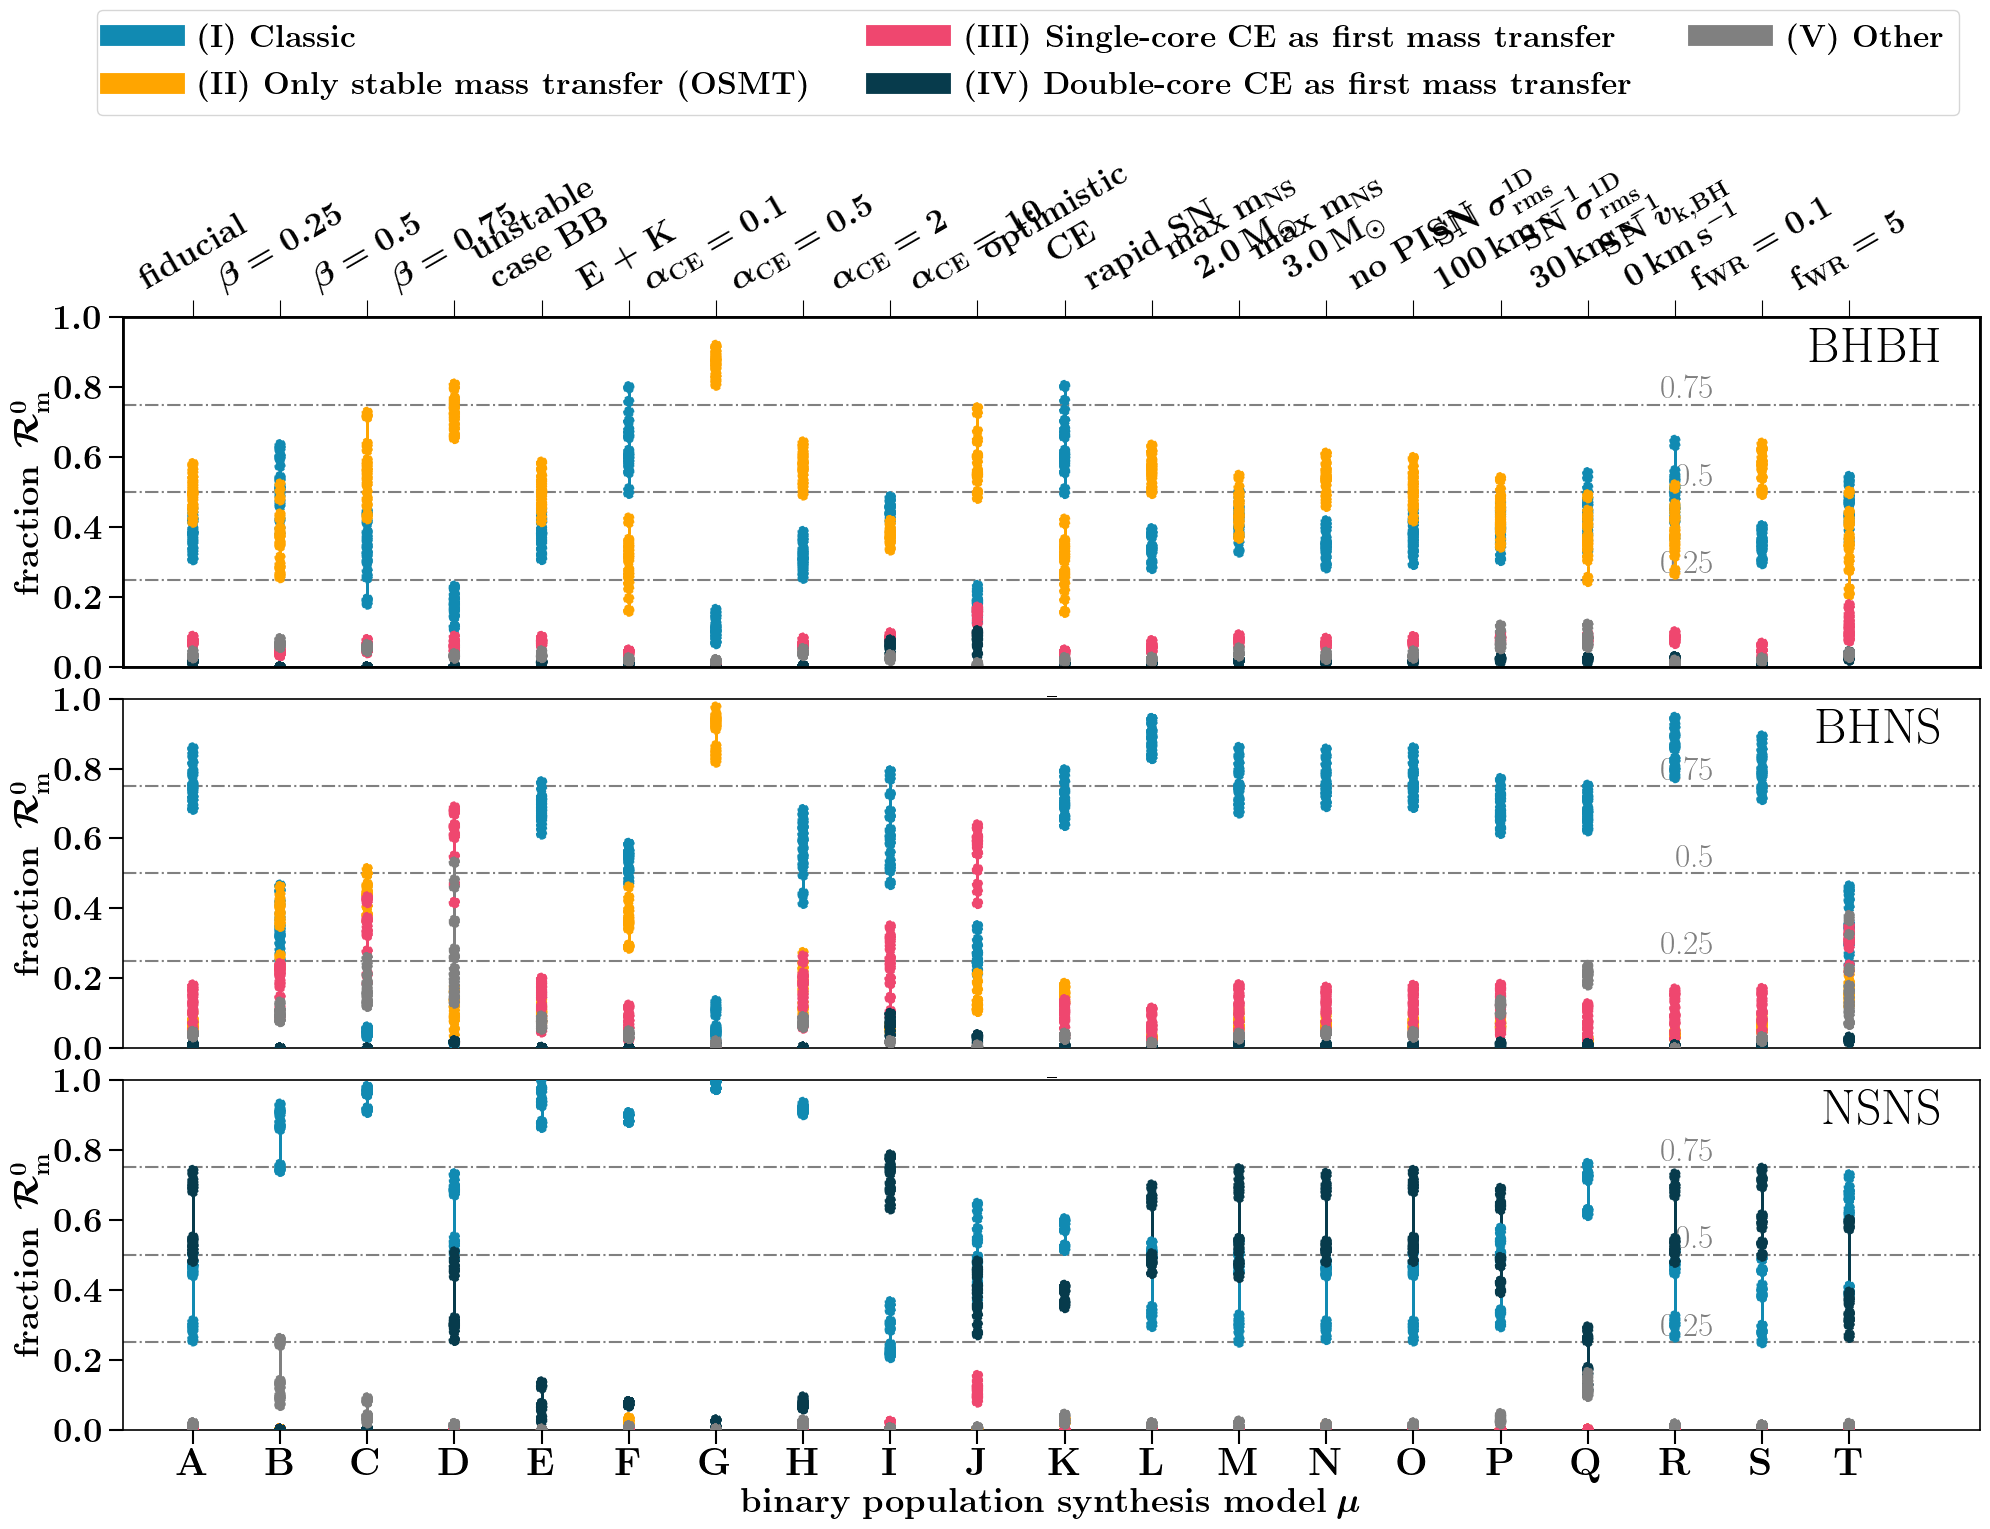

running for z= 8.653846153846153
at DCO type BBH
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BHNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20
at DCO type BNS
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
20


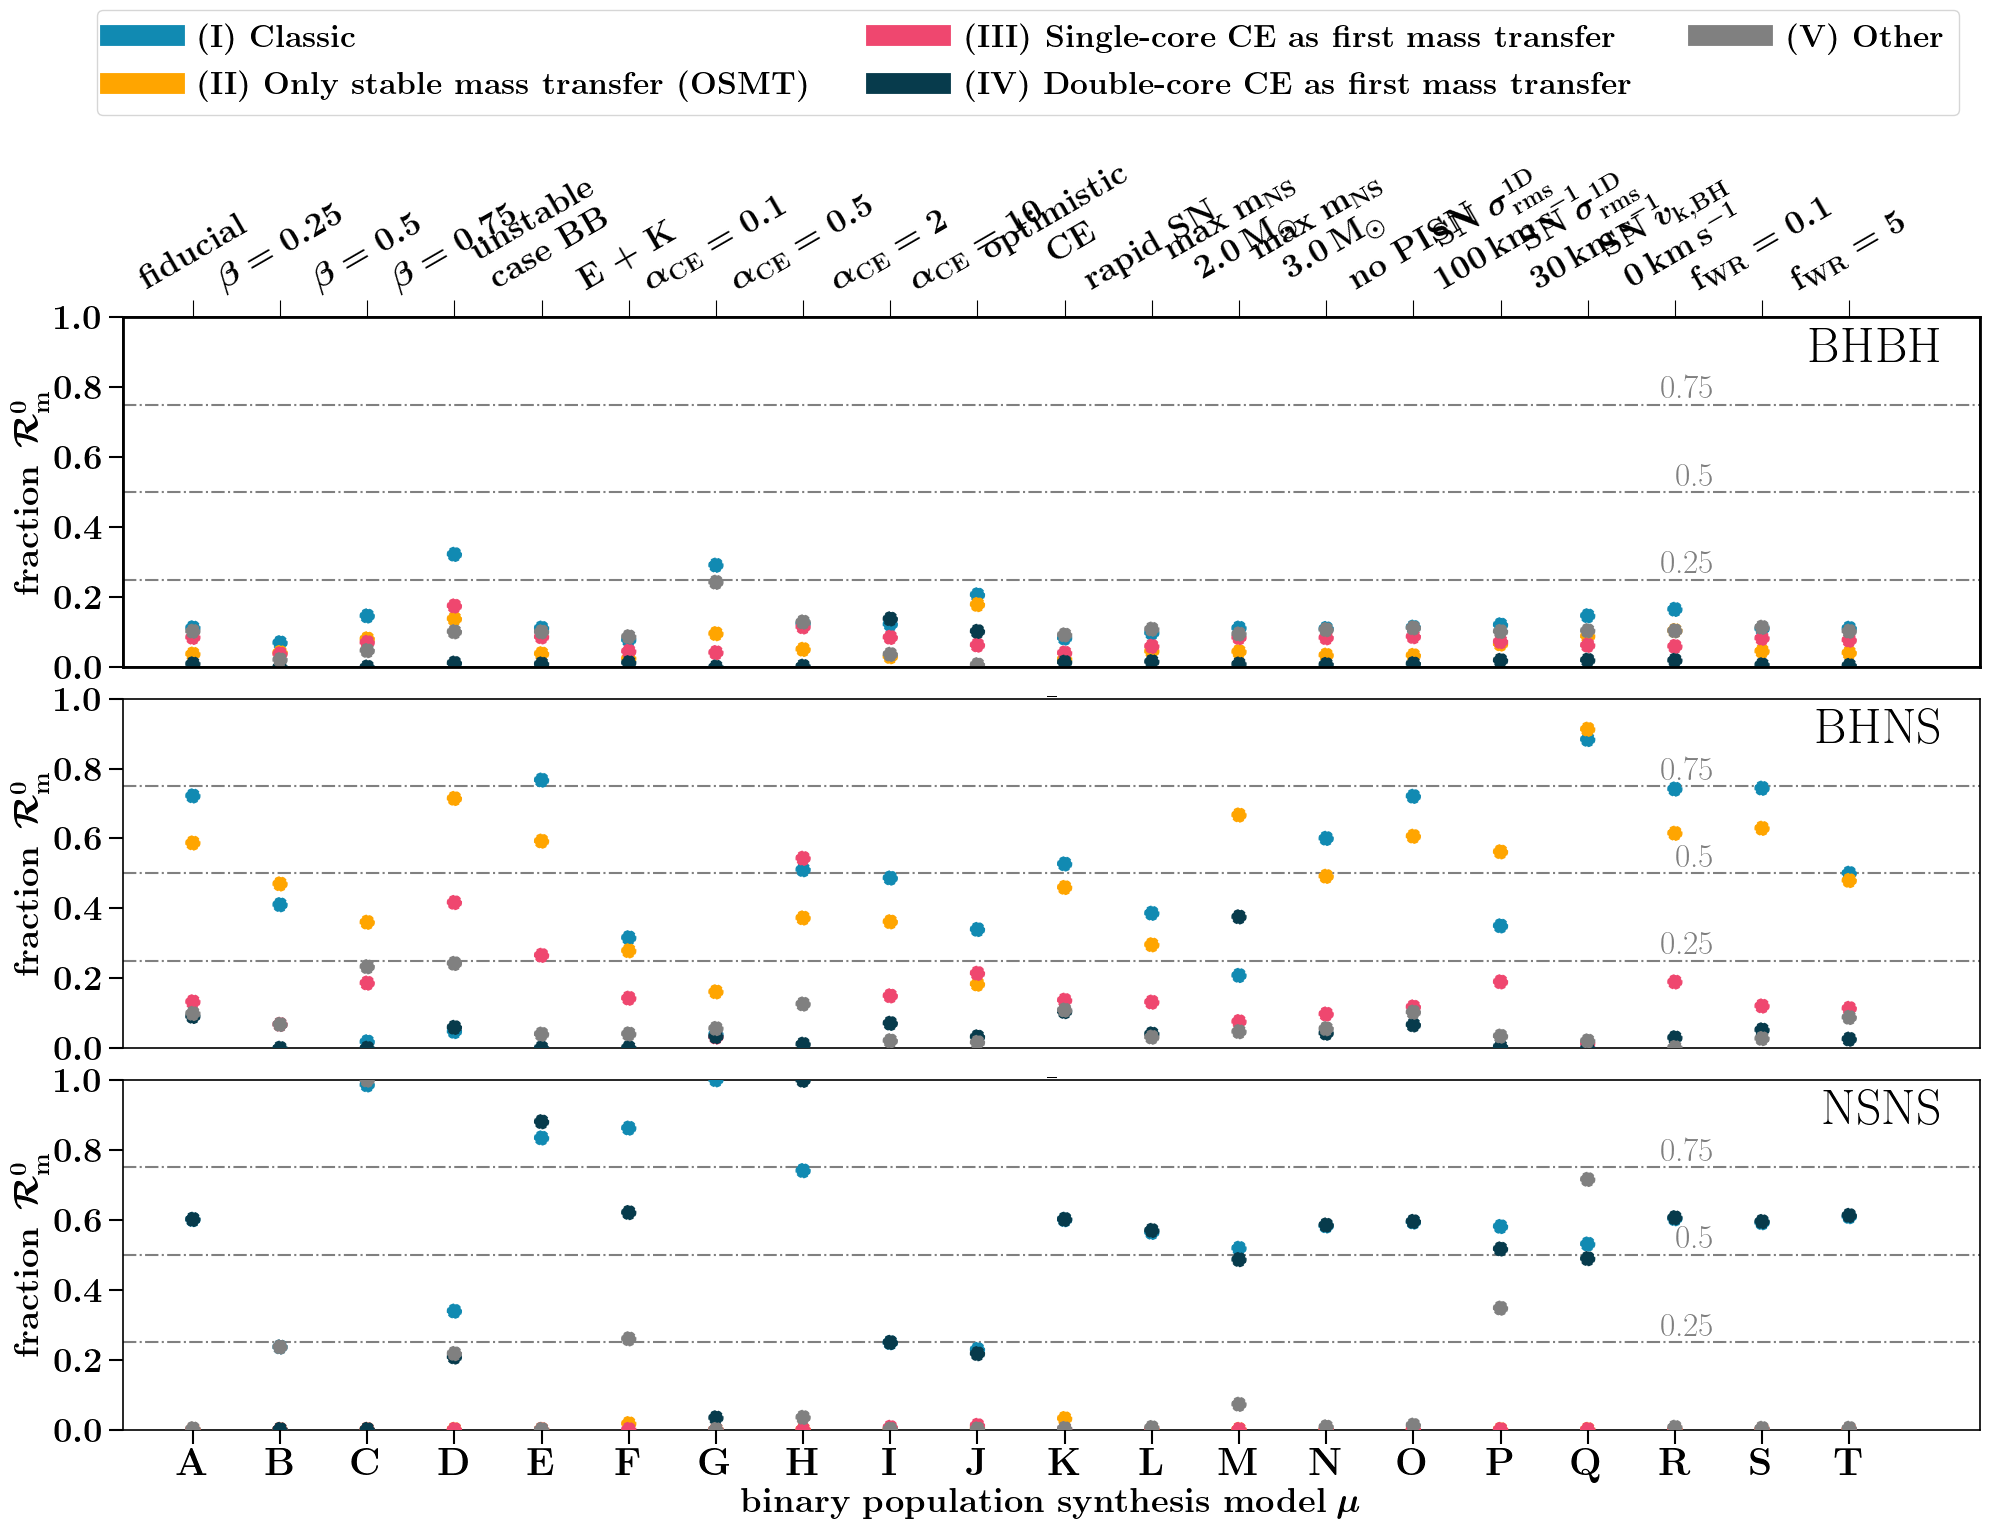

In [10]:
def plotFormationChannelRates_diff_MSSFR(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
    """
    parameters
    
    """
    
    ncols=1
    nrows=3
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,14), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']

    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    

    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

    
    # calculate the redshift at which to run it for 
    redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
    print('running for z=', redshifts[which_z_ind])
    whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
    #Iterate over DCO type
    for ind_t, DCOtype in enumerate(Types):
        print('at DCO type', DCOtype)
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]
    
        #iterate over the formation channels 
        for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE',  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
#             merger_ratio_z = np.zeros(nModels)
            #iterate over stellar evolution models 
            for ind_m, BPSmodelName in enumerate(BPSnameslist):
                full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
                fparam_key = "formationchannel_z_rates"
                
                
#                 ratios_MSSFR = np.asarray(MSSFRname)
                merger_ratio_z = np.zeros(len(MSSFRnameslist))
                for ind_L, MSSFRname in enumerate(MSSFRnameslist):
                    
                    header = "fraction_" + whichChannel + "_" + MSSFRname
                    fdata = h5.File(full_data_path,'r')
                    merger_ratio_z[ind_L] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
#                     fdata.close()
                    
                    if whichChannel=='classic':
                        header = "fraction_" + 'vi' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
                    elif whichChannel=='stable B no CEE':
                        header = "fraction_" + 'vii' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

                    fdata.close()
                


                ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'    



#                 if MSSFRname=='112':
                zorder=10
                label=MSSFRnameslist[ind_L] 
                ls = MSSFRlinestyles[1]
                ALPHA=1
#                 elif MSSFRname=='312':
#                     zorder=10
#                     label=MSSFRnameslist[ind_L]
#                     ls = MSSFRlinestyles[2]
# #                     print('label=', label)
#                     ALPHA=1
#                 else:
#                 zorder=2
#                 label=None    
#                 ls = MSSFRlinestyles[0]
#                 ALPHA=0.1


                ratesRatio = merger_ratio_z
                ind_color = dictFormationChannelIndex[whichChannel]
                axe.plot([range(len(ratesRatio))[ind_m]]*1, [np.max(ratesRatio)- np.min(ratesRatio)], c=channelColorDict[whichChannel], lw=2, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
                axe.scatter([range(len(ratesRatio))[ind_m]]*1, [np.max(ratesRatio)- np.min(ratesRatio)], c=channelColorDict[whichChannel], s=100, label=None, zorder=zorder+1, alpha=1, linestyle=ls) #c=BPScolors




        xmin = -0.8
        xmax = nModels +0.5 # change to len(df.T)
        xx = np.linspace(xmin,xmax,15)


        for ll in [0.25, 0.5, 0.75]:
            axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=1.5, zorder=0)
            axe.text(17.5-0.04, ll, str(ll) +r'$\,$' , rotation = 0, fontsize = fs-4, color = 'gray', va='bottom', ha = 'right')#, weight = 'bold')
        axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )



#       # make up axes
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model} $\mu$'
        else:
            xlabel=r'  $\_$ '

        axe.set_xlim(xmin, xmax)
        axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
#             axe.set_yscale('log')

        print(BPSnameslist)
        print(nModels)
        # set physical labels on bottom
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
            ind_label = dictFormationChannelIndex[whichChannel]-1
        else:
            axe.set_xticks([])
            axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.98, 0.97, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', va='top', ha = 'right',transform=axe.transAxes)#, weight = 'bold')



        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)

            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-4, rotation=30)#, orientation=30)    
     

    ## make legend 
    x__ = -100*np.ones(5)
    for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii',
        plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
    lgd = f.legend(fontsize=fs-5, ncol=3,bbox_to_anchor=(.99, 1.10)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.09)#2)
#     plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight') #, loc='upper center')
    plt.show()
    plt.close()

    return


pathData='/Volumes/SimonsFoundation/DataDCO/'
# ylims =[[0,1.03],[0,1.03],[0,1.03]]
ylims =[[0,1],[0,1],[0,1]]
plotFormationChannelRates_diff_MSSFR(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=-4)





In [16]:
A  = np.asarray([1,2,3,4,5])

print(A[1::2])

[2 4]


'#8da0cb'

running for z= 9.03846153846154
at DCO type BBH
at DCO type BHNS
at DCO type BNS


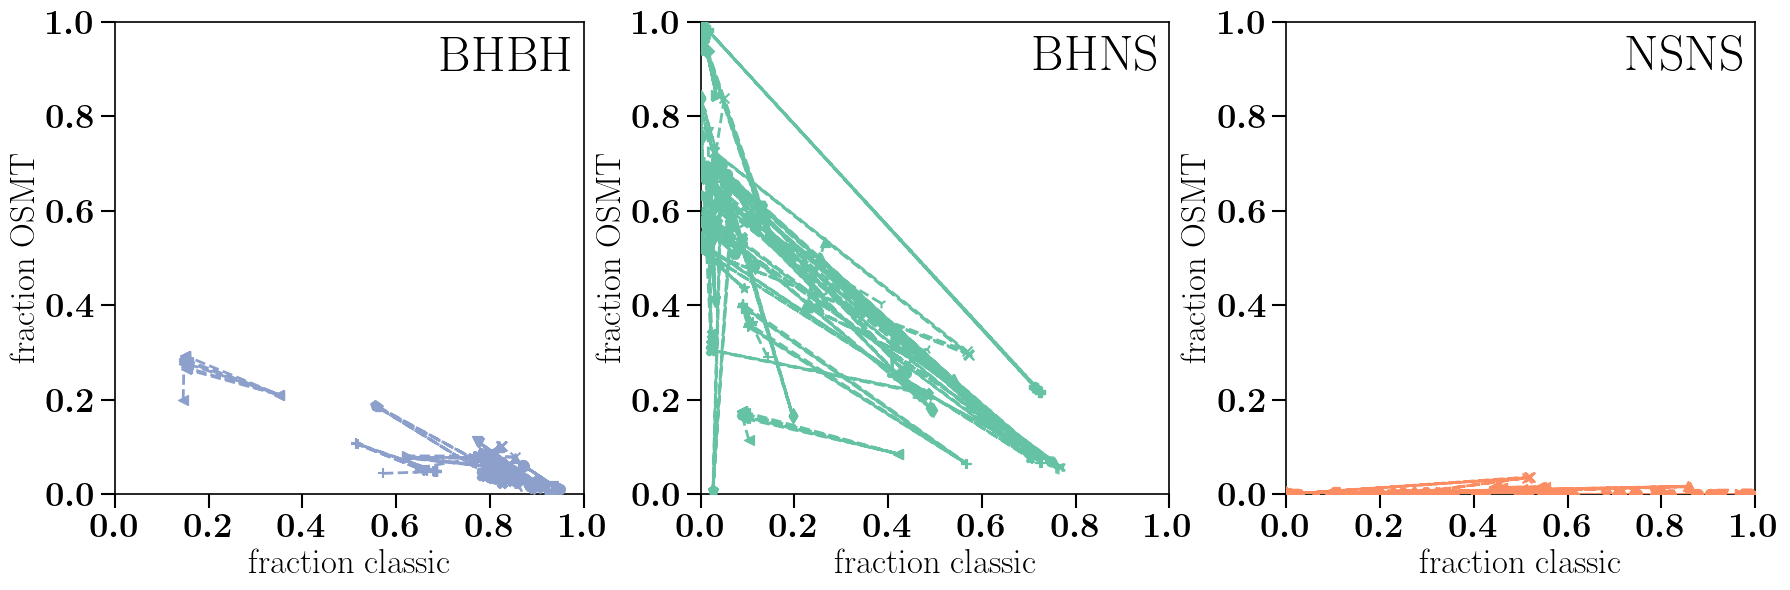

In [38]:
def plotFormationChannelRates_2D_fc(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
    """
    parameters
    
    """
    
    ncols=3
    nrows=1
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(18,6), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']

    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'    
    zorder=10  
    ls = MSSFRlinestyles[1]
    ALPHA=1    
    label=MSSFRnameslist[0] 

    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

    
    # calculate the redshift at which to run it for 
    redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
    print('running for z=', redshifts[which_z_ind])
    whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
    #Iterate over DCO type
    for ind_t, DCOtype in enumerate(Types):
        print('at DCO type', DCOtype)
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]
        dco_color = DCOtypeColorsDict[DCOtype]
    
        #iterate over the formation channels 

            #iterate over stellar evolution models 
        for ind_m, BPSmodelName in enumerate(BPSnameslist):
            full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
            fparam_key = "formationchannel_z_rates"
            marker_shape_bps = dictMarkerShape[BPSmodelName]
            
            for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE']): #,  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
    #             merger_ratio_z = np.zeros(nModels)
                
#                 ratios_MSSFR = np.asarray(MSSFRname)
                merger_ratio_z = np.zeros(len(MSSFRnameslist))
                for ind_L, MSSFRname in enumerate(MSSFRnameslist):
                    
                    header = "fraction_" + whichChannel + "_" + MSSFRname
                    fdata = h5.File(full_data_path,'r')
                    merger_ratio_z[ind_L] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
#                     fdata.close()
                    
                    if whichChannel=='classic':
                        header = "fraction_" + 'vi' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
                    elif whichChannel=='stable B no CEE':
                        header = "fraction_" + 'vii' + "_" + MSSFRname
                        merger_ratio_z[ind_L] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

                    
                if ind_c==0:
                    fc_x = merger_ratio_z
                elif ind_c==1:
                    fc_y = merger_ratio_z
                    


                
            axe.plot(   fc_x, fc_y, c=dco_color, lw=2, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
            axe.scatter(fc_x, fc_y, c=dco_color, s=50, label=None, zorder=zorder+1, alpha=1, marker=marker_shape_bps)#, linestyle=ls) #c=BPScolors
            
            
            
            fdata.close()


#         xmin = -0.8
#         xmax = nModels +0.5 # change to len(df.T)
#         xx = np.linspace(xmin,xmax,15)


#         for ll in [0.25, 0.5, 0.75]:
#             axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=1.5, zorder=0)
#             axe.text(17.5-0.04, ll, str(ll) +r'$\,$' , rotation = 0, fontsize = fs-4, color = 'gray', va='bottom', ha = 'right')#, weight = 'bold')
#         axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )



#       # make up axes
#         if ind_t ==2:
#             xlabel = r'\textbf{binary population synthesis model} $\mu$'
#         else:
#             xlabel=r'  $\_$ '

        xlabel = 'fraction classic'
        ylabel = 'fraction OSMT'

        axe.set_xlim(0,1)
        axe.set_ylim(0,1)
        axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
#             axe.set_yscale('log')

#         print(BPSnameslist)
#         print(nModels)
        # set physical labels on bottom
#         if ind_t==2:
#             physicalnames = []
#             for ind_m, bps_model in enumerate(BPSnameslist):
#                 physicalnames.append(r'\textbf{%s}'%(bps_model) )
#             axe.set_xticks(range(nModels))
#             axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

#             axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
#             ind_label = dictFormationChannelIndex[whichChannel]-1
#         else:
#             axe.set_xticks([])
#             axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.98, 0.97, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', va='top', ha = 'right',transform=axe.transAxes)#, weight = 'bold')





#     ## make legend 
#     x__ = -100*np.ones(5)
#     for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii',
#         plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
#     lgd = f.legend(fontsize=fs-5, ncol=3,bbox_to_anchor=(.99, 1.10)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  

    
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.09)#2)
#     plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight') #, loc='upper center')
    plt.show()
    plt.close()

    return


pathData='/Volumes/SimonsFoundation/DataDCO/'
# ylims =[[0,1.03],[0,1.03],[0,1.03]]
ylims =[[0,1],[0,1],[0,1]]
plotFormationChannelRates_2D_fc(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
                       pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=-3)





running for z= 0.19230769230769232
at DCO type BBH


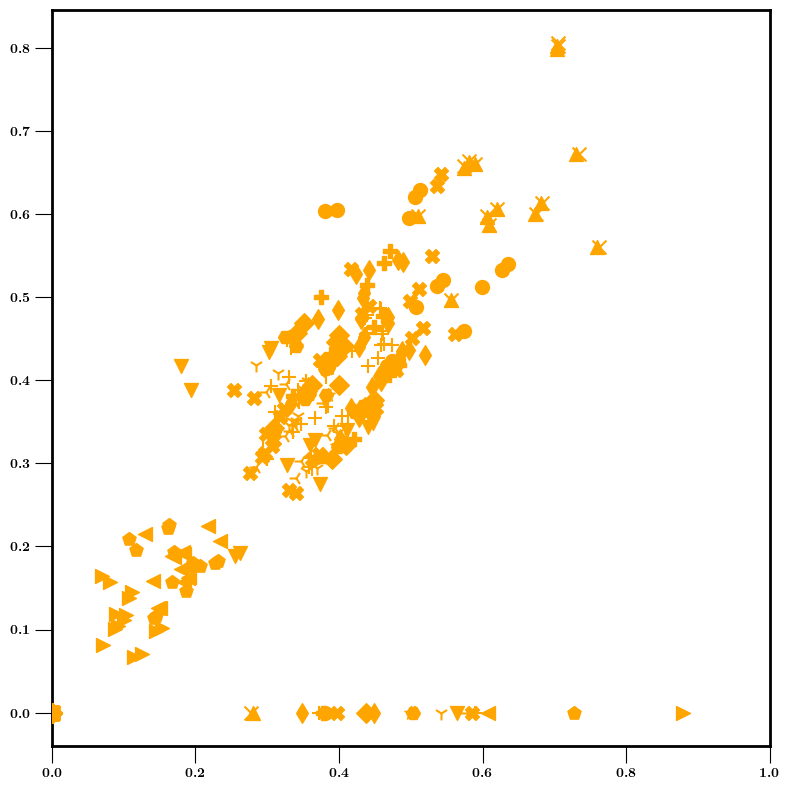

In [23]:
# # not per model but everything together:





# def plotFormationChannelRates_together(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
#                        pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0):
    
#     """
#     parameters
    
#     """
    
#     ncols=1
#     nrows=1
#     f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(8,8), 
#                   gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
#     Types      = ['BBH', 'BHNS', 'BNS']
#     TypesLabels      = ['BHBH', 'BHNS', 'NSNS']

#     MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    

#     channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
#     List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
#     ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
#     dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

    
#     # calculate the redshift at which to run it for 
#     redshifts = obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/')
#     print('running for z=', redshifts[which_z_ind])
#     whichz = str(np.round(redshifts[which_z_ind], 4))  
    
    
#     #Iterate over DCO type
# #     for ind_t, DCOtype in enumerate(Types):
#     print('at DCO type', DCOtype)
# #     axe = axes[ind_t]
#     DCOname = DCOname_dict[DCOtype]

#     #iterate over the formation channels 
#     DCOtype = 'BBH'

#     #iterate over stellar evolution models 
#     for ind_m, BPSmodelName in enumerate(BPSnameslist):
#         full_data_path  = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
#         fparam_key = "formationchannel_z_rates"
#         fdata = h5.File(full_data_path,'r')
#         marker_shape_bps = dictMarkerShape[BPSmodelName]

# #                 ratios_MSSFR = np.asarray(MSSFRname)
#         fc_list = ['classic', 'stable B no CEE']
#         merger_ratio_z = np.zeros(int(len(MSSFRnameslist)*len(fc_list)))
#         for ind_L, MSSFRname in enumerate(MSSFRnameslist):
            
            
#             for ind_c, whichChannel in enumerate(fc_list):#,  'immediate CE',  r'double-core CE', 'other']): #  'vii','vi'
#                 ind_com = int(ind_L + ind_c)
#                 header = "fraction_" + whichChannel + "_" + MSSFRname
#                 merger_ratio_z[ind_com] = fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift
                
#                 if whichChannel=='classic':
#                     header = "fraction_" + 'vi' + "_" + MSSFRname
#                     merger_ratio_z[ind_com] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  
#                 elif whichChannel=='stable B no CEE':
#                     header = "fraction_" + 'vii' + "_" + MSSFRname
#                     merger_ratio_z[ind_com] += fdata[fparam_key][header][...].squeeze()[which_z_ind]  # [which_z_ind = 0] gives at lowest redshift  

#         fdata.close()




#         zorder=10
#         label=MSSFRnameslist[ind_L] 
#         ls = MSSFRlinestyles[1]
#         ALPHA=1
 
#         ind_color = dictFormationChannelIndex[whichChannel]
# #         axe.plot(merger_ratio_z[0::2], merger_ratio_z[1::2], c=channelColorDict[whichChannel], lw=2, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
#         axe.scatter(merger_ratio_z[0::2], merger_ratio_z[1::2], c=channelColorDict[whichChannel], s=100, label=None, zorder=zorder+1, alpha=1, marker=marker_shape_bps) #c=BPScolors




# #         xmin = -0.8
# #         xmax = nModels +0.5 # change to len(df.T)
# #         xx = np.linspace(xmin,xmax,15)


# #         for ll in [0.25, 0.5, 0.75]:
# #             axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=1.5, zorder=0)
# #             axe.text(17.5-0.04, ll, str(ll) +r'$\,$' , rotation = 0, fontsize = fs-4, color = 'gray', va='bottom', ha = 'right')#, weight = 'bold')
# #         axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )



# # #   # make up axes
# #     if ind_t ==2:
# #         xlabel = r'\textbf{binary population synthesis model} $\mu$'
# #     else:
# #         xlabel=r'  $\_$ '

# #     axe.set_xlim(xmin, xmax)
# #     axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
# # #             axe.set_yscale('log')

# #     print(BPSnameslist)
# #     print(nModels)
# #     # set physical labels on bottom
# #     if ind_t==2:
# #         physicalnames = []
# #         for ind_m, bps_model in enumerate(BPSnameslist):
# #             physicalnames.append(r'\textbf{%s}'%(bps_model) )
# #         axe.set_xticks(range(nModels))
# #         axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

# #         axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
# #         ind_label = dictFormationChannelIndex[whichChannel]-1
# #     else:
# #         axe.set_xticks([])
# #         axe.set_xticklabels( () )

# #     # add name of DCO type
# #     axe.text(0.98, 0.97, TypesLabels[ind_t] , rotation = 0, fontsize = fs+8, color = 'k', va='top', ha = 'right',transform=axe.transAxes)#, weight = 'bold')



# #     ##### SECOND AXIS ######
# #     # add physical name labels on top
# #     if ind_t==0:
# #         physicalnames=[]
# #         for ind_m, bps_model in enumerate(BPSnameslist):
# #             physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
# #         ax2y = axe.twiny()
# #         ax2y.set_xlim(xmin, xmax)

# #         ax2y.set_xticks(range(nModels))
# #         ax2y.set_xticklabels(physicalnames, fontsize=fs-4, rotation=30)#, orientation=30)    
     

# #     ## make legend 
# #     x__ = -100*np.ones(5)
# #     for _, channel in enumerate([ 'classic',  'stable B no CEE', 'immediate CE', r'double-core CE', 'other']): #'vii',
# #         plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
# #     lgd = f.legend(fontsize=fs-5, ncol=3,bbox_to_anchor=(.99, 1.10)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  
#     axe.set_xlim(0,1)
# #     axe.set_ylim(0,1)
#     ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'    
    
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0., hspace=0.09)#2)
# #     plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=100, transparent=False,\
# #                bbox_extra_artists=(lgd,), bbox_inches='tight')
# #     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '.png', dpi=100, transparent=False,\
# #                bbox_extra_artists=(lgd,), bbox_inches='tight') #, loc='upper center')
#     plt.show()
#     plt.close()

#     return


# pathData='/Volumes/SimonsFoundation/DataDCO/'
# # ylims =[[0,1.03],[0,1.03],[0,1.03]]
# ylims =[[0,1],[0,1],[0,1]]
# plotFormationChannelRates_together(DCOtype='BBH', BPSmodelName='A', whichChannel='classic', \
#                        pathData = '/Volumes/SimonsFoundation/DataDCO/', which_z_ind=0)








# OLDER CODE 
#code below is run using the script write_formation_channel_rates_to_CSV.py in `Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/produceDataCode`


In [ ]:

def draw_arrows(axes=None):

    
    textbox_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.3)
    

    ar_c = 'k' #'turquoise'
    ar_lw=4
    
    # BHBH
    axe =axes[0]
    # properties  arrow 
    strr = r"\textbf{Only Stable}" + '\n' + r'\textbf{Mass Transfer}' + '\n'   + r"\textbf{channel (II)}" + '\n'   + r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.7
    x_xytext, y_xytext = 21.8, 0.3
    conn = "angle3,angleA=90,angleB=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)    
    
    
    

    # BHNS 
    axe =axes[1]
    # properties  arrow 
    strr = r"\textbf{Classic CE}" + '\n' + r'\textbf{channel (I)}' + '\n' +r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.14
    x_xytext, y_xytext = 20.9, 0.54
    conn = "angle,angleA=-90,angleB=180,rad=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)
    
    
    
    # NSNS 
    axe =axes[2]
    # properties  arrow 
    strr = r"\textbf{Double-core CE}" + '\n' + r'\textbf{channel (IV)}' + '\n' +r"\textbf{contribution} "
    x_xy, y_xy = 19.1, 0.7
    x_xytext, y_xytext = 20.9, 0.3
    conn = "angle3,angleA=90,angleB=0"

    # draw arrow
    axe.annotate(strr,
      xy=(x_xy, y_xy), xycoords='data',
      xytext=(x_xytext, y_xytext), textcoords='data',
      size=15, va="center", ha="right", bbox=textbox_props,
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", ec=ar_c , lw=ar_lw), zorder=20000)
    
    return 



def plotFormationChannelRates_vbars(whichRate='intrinsic', CSVdir='name'):
    
    """
    parameters
    
    """
    
    ncols=1
    nrows=3
    f, axes= plt.subplots(ncols=ncols,nrows=nrows,figsize=(22,14), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']
#     MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    
    channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
    List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
    ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}
    ind_number_values = int(len(ind_formationchannelOptions)*2)
    
    dx = 0.4 #0.3
    dxrange = np.linspace(-dx, +dx, len(MSSFRnameslist)+1) #+ ind_m
    dxlen = (2*dx)/len(MSSFRnameslist)
    

    for ind_t, DCOtype in enumerate(Types):
        print()
        axe = axes[ind_t]
        DCOname = DCOname_dict[DCOtype]
#         stringgg =  'formation_channels_test_bugfix'
        stringgg =  'formation_channels'
        csvPath = '/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/dataFiles/data_Fig_1/Formation_yields_'  + stringgg + '_'  + DCOname + 'fast.csv'     

        df_name = csvPath
        df = pd.read_csv(df_name, index_col=0).T

        for ind_L, MSSFRname in enumerate(MSSFRnameslist):
            ratesRatio_low = np.zeros(nModels)
            ratesRatio     = np.zeros(nModels)
            
            x_positions_ = range(nModels)
            xx_ = dxrange[ind_L]
            x_positions = np.asarray(x_positions_) + xx_

                
            key_mssfr = MSSFRheaderDict[MSSFRname]
            rates_L = df[key_mssfr]
            

                
            for ind_c, whichChannel in enumerate(['classic', 'stable B no CEE', 'vii',  'immediate CE',  r'double-core CE', 'other', 'vi']):

                if whichRate =='intrinsic':
                    ind_wanted = dictFormationChannelIndex[whichChannel]*2
                    rates = rates_L[ind_wanted::16][0:nModels]
                    totalrates = rates_L[14::16][0:nModels]

                    if ind_L==0:
                        print('the intrinsic fiducial rate for ', DCOtype ,'=',rates[0]) 
                    ylabel = r'\textbf{fraction} $\,\mathcal{R}_{\rm{m}}^{{0}}$'


                elif whichRate=='observed':
                    ind_wanted = (dictFormationChannelIndex[whichChannel]*2) +1
                    rates = rates_L[ind_wanted::16][0:nModels]
                    totalrates = rates_L[15::16][0:nModels]
                    if ind_L==0:
                        print('the observed fiducial rate for ', DCOtype ,'=',rates[0])   
                    ylabel = r'\textbf{fraction} $\, \mathcal{R}_{\rm{det}}$'

                
                ratesRatio += np.asarray(rates)/np.asarray(totalrates)
                
                axe.bar(x_positions, height=(ratesRatio-ratesRatio_low),  bottom=ratesRatio_low, color=channelColorDict[whichChannel], alpha=1, \
                       width=dxlen, zorder=100)
                
                ratesRatio_low += np.asarray(rates)/np.asarray(totalrates)
                

        
        # draw custom grid lines in plot 
        xmin, xmax = -0.8, nModels +1. # change nModels + 1 to len(df.T)
        xx = np.linspace(xmin,xmax,15) # just mock x-axes to draw lines
        for ll in [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            axe.plot(xx, ll*np.ones_like(xx), c='gray', linestyle='dashdot', lw=0.9, zorder=0)
        axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )


#       # make up axes
        if ind_t ==2:
            xlabel = r'\textbf{binary population synthesis model}'
        else:
            xlabel=r'  $\_$ '

        axe.set_xlim(xmin, xmax)
        axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)


        # set physical labels on bottom
        if ind_t==2:
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[ind_t][0], ylims[ind_t][1] )
            ind_label = dictFormationChannelIndex[whichChannel]-1
        else:
            axe.set_xticks([])
            axe.set_xticklabels( () )
            
        # add name of DCO type
        axe.text(0.99, 0.94, r'\textbf{%s}'%TypesLabels[ind_t] , rotation = 0, fontsize = fs+3, color = 'k', va='top', ha = 'right',transform=axe.transAxes, zorder=1E3)#, weight = 'bold')
        axe.text(0.99, 0.85, r'\textbf{detections}' , rotation = 0, fontsize = 17, color = 'k', va='top', ha = 'right',transform=axe.transAxes, zorder=1E3)#, weight = 'bold')



        ##### SECOND AXIS ######
        # add physical name labels on top
        if ind_t==0:
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)
            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-6, rotation=30)#, orientation=30)    
     

    
    ## make legend 
    x__ = -100*np.ones(5)
    for _, channel in enumerate([ 'classic',  'stable B no CEE', 'vii','immediate CE', r'double-core CE', 'other']):
        plt.plot(x__,x__ , lw=15, color=channelColorDict[channel], label = dictChannelsBHNSListBolt[channel])    
    lgd = f.legend(fontsize=fs-1, ncol=2,bbox_to_anchor=(.85, 1.115)) #,  markerscale=2., scatterpoints=1) # loc = 'upper center')  

    
#     draw_arrows(axes=axes)


    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.11)#2)
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '_vbars.pdf', transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')#, loc='upper center')
#     plt.savefig('./extra_figures/FormationChannels_' + whichRate  + '_vbars.png', dpi=100, transparent=False,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')#, loc='upper center')
    plt.show()
    plt.close()
    
    print()
    
    return






# nModels=20


In [ ]:
# # fixed uncomment the following:
# CSVdir = '/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/dataFiles/data_Fig_1'
# ylims =[[0,1.1],[0,1.1],[0,1.1]]
# plotFormationChannelRates_vbars(whichRate='observed', CSVdir=CSVdir)

# # Floor: note 24-2-2021 these are the OLD rates !!! Replace accordingly with new data 
# CSVdir = '/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/dataFiles/data_Fig_1'
# ylims =[[0,1.1],[0,1.1],[0,1.1]]
# plotFormationChannelRates_vbars(whichRate='intrinsic', CSVdir=CSVdir)




